In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import time

print(tf.config.list_physical_devices('GPU'))

2023-01-12 17:14:04.259028: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-12 17:14:06.485149: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-12 17:14:06.497182: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-12 17:14:06.596802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2023-01-12 17:14:06.596895: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-12 17:14:06.648589: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-12 17:14:06.648791: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-0

In [2]:
# Pour activer la croissance de la mémoire pour un GPU spécifique
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
tf.debugging.set_log_device_placement(True)

1 Physical GPUs, 1 Logical GPUs


2023-01-12 17:14:06.869725: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 17:14:06.871183: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-12 17:14:06.872034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2023-01-12 17:14:06.872103: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-12 17:14:06.872134: I tensorflow/stream_executor/platform/def

In [4]:
# class Normalization(tf.keras.layers.Layer):
#     def __init__(self, axis=-1):
#         super(Normalization, self).__init__()
#         if isinstance(axis, int):
#             self.axis=axis
#         elif isinstance(axis, (list, tuple)):
#             self.axis = axis
#         else:
#             raise TypeError("Invalid value for axis: expected a int "
#                             "or list/tupple of ints"
#                             f"Received: axis={axis}"
#                            )
        
#     def build(self, input_shape):
#         if tf.math.reduce_max(tf.math.abs(self.axis)).numpy() > len(input_shape):
#             raise InvalidArgumentError("Invalid reduction dimension"
#                                        f"{axis} for input of shape {input_shape}"
#                                       )
    
#     def call(self, inputs):
#         return tf.linalg.l2_normalize(inputs, axis=self.axis)

# data = tf.constant(np.arange(1,13).reshape(2, 3, 2), dtype=tf.float32)
# nor=Normalization((1,2))(data)    
# print(tf.reduce_sum(nor[0,:]**2, axis=(0,1)).numpy())

# Load datasets

In [3]:
path = "New Data/"
path_to_label0 = path+"0scaled_params.csv"
path_to_label1 = path+"1scaled_params.csv"
path_to_label2 = path+"2scaled_params.csv"
path_to_label3 = path+"3scaled_params.csv"
path_to_label4 = path+"4scaled_params.csv"

path_to_input0 = path+"0CBLV.npy"
path_to_input1 = path+"1CBLV.npy"
path_to_input2 = path+"2CBLV.npy"
path_to_input3 = path+"3CBLV.npy"
path_to_input4 = path+"4CBLV.npy"

params_to_infer = ["mean_signal", "amplitude", "import_param"]

nb_estimates = len(params_to_infer)

inputs0 = np.transpose(np.load(path_to_input0), axes=(0, 2, 1))
inputs1 = np.transpose(np.load(path_to_input1), axes=(0, 2, 1))
inputs2 = np.transpose(np.load(path_to_input2), axes=(0, 2, 1))
inputs3 = np.transpose(np.load(path_to_input3), axes=(0, 2, 1))
inputs4 = np.transpose(np.load(path_to_input4), axes=(0, 2, 1))

labels0 = pd.read_csv(path_to_label0)[params_to_infer].to_numpy()
labels1 = pd.read_csv(path_to_label1)[params_to_infer].to_numpy()
labels2 = pd.read_csv(path_to_label2)[params_to_infer].to_numpy()
labels3 = pd.read_csv(path_to_label3)[params_to_infer].to_numpy()
labels4 = pd.read_csv(path_to_label4)[params_to_infer].to_numpy()


# Check shapes
print('inputs shape:', inputs0.shape)
print('labels shape:', labels0.shape)
print('inputs shape:', inputs1.shape)
print('labels shape:', labels1.shape)
print('inputs shape:', inputs2.shape)
print('labels shape:', labels2.shape)
print('inputs shape:', inputs3.shape)
print('labels shape:', labels3.shape)
print('inputs shape:', inputs4.shape)
print('labels shape:', labels4.shape)

inputs shape: (16689, 600, 2)
labels shape: (16689, 3)
inputs shape: (146378, 600, 2)
labels shape: (146378, 3)
inputs shape: (172287, 600, 2)
labels shape: (172287, 3)
inputs shape: (233439, 600, 2)
labels shape: (233439, 3)
inputs shape: (274119, 600, 2)
labels shape: (274119, 3)


In [48]:
inputs = np.concatenate((inputs3, inputs4[600:,]), axis=0)
labels = np.concatenate((labels3, labels4[600:,]), axis=0)

# inputs = np.concatenate((inputs0, inputs1, inputs2, inputs3), axis=0)
# labels = np.concatenate((labels0,labels1, labels2, labels3), axis=0)

print("label concatenation: ", labels.shape)
print("input concatenation:", inputs.shape)

label concatenation:  (506958, 3)
input concatenation: (506958, 600, 2)


## *Normalize Inputs and Outputs*

In [49]:
MAX_features = np.load(path+"bound_features.npy")
E = np.load(path+"bound_labels.npy")
MAX_labels, MIN_labels = E[:3], E[3:]

In [50]:
# MAX_features = np.max(inputs, axis=(0,1))
print(MAX_features)

# MIN_labels = np.min(labels, axis=0)
# MIN_labels[1] = 0.1
print(MIN_labels)
# MAX_labels = np.max(labels, axis=0)
# MAX_labels[1], MAX_labels[2] = 1, 15
print(MAX_labels)

# np.save(path+"bound_features.npy", MAX_features)
# np.save(path+"bound_labels.npy", np.concatenate((MAX_labels, MIN_labels), axis=0))

norm_inputs = inputs/MAX_features[None, :]
norm_labels = (labels-MIN_labels[None, :])/(MAX_labels[None, :]-MIN_labels[None, :])

print(norm_inputs.shape)
print(norm_labels.shape)

[59.15544517 57.92463666]
[2.10405211 0.1        0.01231017]
[ 8.49434372  1.         15.        ]
(506958, 600, 2)
(506958, 3)


In [54]:
PROP_TRAIN =  0.98
num_train = int(labels.shape[0]*PROP_TRAIN)

x_train, y_train = norm_inputs[:num_train, :, :], norm_labels[:num_train, :]
x_val, y_val = norm_inputs[num_train:, :, :], norm_labels[num_train:, :]
# x_val, y_val = norm_inputs[num_train:(num_train+num_val), :, :], norm_labels[num_train:(num_train+num_val), :]
# x_test, y_test = norm_inputs[(num_train+num_val):, :, :], norm_labels[(num_train+num_val):, :]
                                                                
train_size = x_train.shape[0]
print(f"There is {train_size} training data, {x_val.shape[0]} validation data")

There is 496818 training data, 10140 validation data


# Design models

In [24]:
# layer = layers.Dense(
#     units=64,
#     kernel_regularizer=regularizers.L1(1e-2)
# )

In [7]:
SIZE = 600
inp = tf.random.normal((1, SIZE, 2))

CNN_1 = keras.Sequential(
    [
        keras.Input(shape=(SIZE, 2)),
        layers.Conv1D(filters=50, kernel_size=3),   
        layers.Activation(keras.activations.relu),
        layers.Conv1D(filters=50, kernel_size=10),
        layers.Activation(keras.activations.relu),
        layers.MaxPooling1D(pool_size=10),
        layers.Conv1D(filters=80, kernel_size=10),
        layers.Activation(keras.activations.relu),
        # layers.Dropout(.5),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64),
        layers.Activation(keras.activations.elu),
        layers.Dense(32),
        layers.Activation(keras.activations.elu),
        layers.Dense(16),
        layers.Activation(keras.activations.elu),
        layers.Dense(8),
        layers.Activation(keras.activations.elu),
        layers.Dropout(.2),
        layers.Dense(nb_estimates)
    ]
)
print('CNN1 ')
CNN_1.summary()
print("out", CNN_1(inp))


# CNN_flat = keras.Sequential(
#     [
#         keras.Input(shape=(SIZE, 2)),
#         layers.Conv1D(filters=50, kernel_size=3),
#         layers.Activation(keras.activations.relu),
#         layers.MaxPooling1D(pool_size=10),
#         layers.Conv1D(filters=80, kernel_size=10),
#         layers.Activation(keras.activations.relu),
#         # layers.Dropout(.5),
#         layers.Flatten(),
#         layers.Dense(1024, activation="elu"),
#         layers.Dense(128),
#         # layers.Dropout(.2),
#         # layers.BatchNormalization(),
#         layers.Activation(keras.activations.elu),
#         layers.Dense(64),
#         # layers.Dropout(.2),
#         # layers.BatchNormalization(),
#         layers.Activation(keras.activations.elu),
#         layers.Dense(32),
#         # layers.Dropout(.2),
#         # layers.BatchNormalization(),
#         layers.Activation(keras.activations.elu),
#         layers.Dense(16),
#         # layers.BatchNormalization(),
#         layers.Activation(keras.activations.elu),
#         layers.Dense(8),
#         layers.Activation(keras.activations.elu),
#         layers.Dropout(.5),
#         layers.Dense(nb_estimates)
#     ]
# )
# print('CNN_flat')
# CNN_flat.summary()
# print('out', CNN_flat(inp))


# CNN_big = keras.Sequential(
#     [
#         keras.Input(shape=(SIZE, 2)),
#         layers.Conv1D(filters=60, kernel_size=3),
#         layers.Activation(keras.activations.relu),
#         # layers.BatchNormalization(),
#         layers.Conv1D(filters=60, kernel_size=10),
#         layers.Activation(keras.activations.relu),
#         # layers.BatchNormalization(),
#         layers.Dropout(0.5),
#         layers.MaxPooling1D(pool_size=10),
#         layers.Conv1D(filters=100, kernel_size=10),
#         layers.Activation(keras.activations.relu),
#         # layers.BatchNormalization(),
#         layers.Dropout(.5),
#         layers.GlobalAveragePooling1D(),
#         layers.Dense(64, activation="elu"),
#         # layers.Dropout(.5),
#         layers.Dense(32, activation="elu"),
#         layers.Dense(16, activation="elu"),
#         layers.Dense(8, activation="elu"),
#         layers.Dropout(.5),
#         layers.Dense(nb_estimates, activation="linear")
#     ]
# )
# print('CNN Big')
# CNN_big.summary()
# print('out', CNN_big(inp))

CNN1 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 598, 50)           350       
_________________________________________________________________
activation (Activation)      (None, 598, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 589, 50)           25050     
_________________________________________________________________
activation_1 (Activation)    (None, 589, 50)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 58, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 49, 80)            40080     
_________________________________________________________________
activation_2 (Activation)    (None, 49, 80)       

2023-01-12 17:15:04.489177: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-01-12 17:15:09.547194: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


out tf.Tensor([[ 0.1580163  -0.39627257 -0.05377956]], shape=(1, 3), dtype=float32)


# Training

In [55]:
def training(model, batch_size=64, num_epochs = 1000, patience=200, min_diff=0.5, loss=tf.keras.losses.MeanAbsolutePercentageError(), optim="adam"):
    
    custom_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=min_diff, patience=patience)
    model.compile(
        optimizer=optim,
        loss=loss,
    )
    
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=num_epochs, callbacks=[custom_early_stop]);
    
    return history

In [56]:
def plot_curves(name_model, history):
    """ Plot learning curves """
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    num_real_epochs = len(train_loss)
    
    plt.figure()
    plt.plot(np.arange(num_real_epochs), train_loss, '-r', label="Training loss")
    plt.plot(np.arange(num_real_epochs), val_loss, '-g', label="Validation loss")
    plt.xlabel('epoch')
    plt.legend()
    plt.title(name_model+": Learning curves for parameters inference")
    
    
    plt.show()

# Testing 

In [40]:
# # Load test data

# params_to_infer = ["mean_signal", "amplitude", "import_param"]

# test_input = np.transpose(np.load(path+"test_CBLV.npy"), axes=(0, 2, 1))
# test_label = pd.read_csv(path+"test_scaled_params.csv")[params_to_infer].to_numpy()

# print('input shape', test_input.shape)
# print('label shape', test_label.shape)

input shape (1889, 600, 2)
label shape (1889, 3)


In [257]:
labels4

array([[ 4.93490958,  0.50740214, 12.5936929 ],
       [ 4.51451212,  0.59347839,  8.22613371],
       [ 4.94874156,  0.2347522 , 13.39096136],
       ...,
       [ 5.70186496,  0.25141528, 13.64279807],
       [ 4.74796931,  0.42121291,  6.25208008],
       [ 5.74658141,  0.1626763 ,  7.72770608]])

In [41]:
# MAX_fs = np.max(test_input, axis=(0,1))
# print(MAX_fs)
# MIN_l = np.min(test_label, axis=0)
# print(MIN_l)
# MAX_l = np.max(test_label, axis=0)
# print(MAX_l)

[54.47045683 52.82928024]
[31.93913814  0.1504336   1.14154233]
[1.51750911e+04 7.75446650e-01 1.49976370e+01]


In [292]:
# MAX_features = np.load(path+"bound_features.npy")
# E = np.load(path+"bound_labels.npy")
# MAX_labels, MIN_labels = E[:3], E[3:]
# def compute_error(model, inputs=x_test*MAX_features, labels=y_test*(MAX_labels - MIN_labels)+MIN_labels, MAX_inp=MAX_features, MIN=MIN_labels, MAX=MAX_labels, plot=True):
def compute_error(model, inputs=inputs4[:600,], labels=labels4[:600,], MAX_inp=MAX_features, MIN=MIN_labels, MAX=MAX_labels, plot=True):
    
    norm_inp = inputs/MAX_inp

    # norm_inp = x_train[:1000]
    # labels = y_train[:1000]*(MAX - MIN) + MIN
    
    RE = tf.math.abs(labels - (MAX-MIN)*model(norm_inp) - MIN )*100/labels
    MRE = tf.reduce_mean(RE, axis=0).numpy()
    
    #  and each parameter
    if plot:
        fig = plt.figure(figsize=(10, 6))
        
        fig.add_subplot(131)
        plt.hist(RE[:,0], rwidth=0.95)
        plt.title(str(round(MRE[0], 1))+"%", fontweight='bold')
        plt.xlabel("Mean")
        
        fig.add_subplot(132)
        plt.hist(RE[:,1], rwidth=0.95)
        plt.xlabel('Amplitude')
        plt.title(str(round(MRE[1], 1))+"%", fontweight='bold')
        
        fig.add_subplot(133)
        plt.hist(RE[:,2], rwidth=0.95)
        plt.xlabel("Import param")
        plt.title(str(round(MRE[2],1))+"%", fontweight='bold')
                            
        return fig
        
    else:
        return(RE, MRE)
    
    
def compare(mod1, mod2, mod3):
    
    RE1, _ = compute_error(mod1, plot=False)
    RE2, _ = compute_error(mod2, plot=False)
    RE3, _ = compute_error(mod3, plot=False)

    fig, ax = plt.subplots(1,1, figsize=(9,6))

    t=np.arange(1,4)
    bp1 = ax.boxplot(RE1.numpy(),positions=t, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C0"), showfliers=False)

    bp2 = ax.boxplot(RE2.numpy(), positions=t+0.2, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C2"), showfliers=False)

    bp3 = ax.boxplot(RE3.numpy(), positions=t+0.4, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C3"), showfliers=False)


    ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['mod1', 'mod2', 'mod3'], loc='upper right')

    ax.set_xticklabels(['', '', '', 'mean', 'amplitude', 'import param', '','',''], fontweight='bold')

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False)         # ticks along the top edge are off


    plt.show()

# Learning

In [1]:
1024*8

8192

Epoch 1/1000
243/243 [==============================] - 26s 96ms/step - loss: 0.0114 - val_loss: 0.0080
Epoch 2/1000
243/243 [==============================] - 22s 89ms/step - loss: 0.0112 - val_loss: 0.0081
Epoch 3/1000
243/243 [==============================] - 22s 90ms/step - loss: 0.0112 - val_loss: 0.0079
Epoch 4/1000
243/243 [==============================] - 22s 91ms/step - loss: 0.0110 - val_loss: 0.0080
Epoch 5/1000
243/243 [==============================] - 22s 92ms/step - loss: 0.0110 - val_loss: 0.0079
Epoch 6/1000
243/243 [==============================] - 22s 92ms/step - loss: 0.0110 - val_loss: 0.0083
Epoch 7/1000
243/243 [==============================] - 22s 93ms/step - loss: 0.0110 - val_loss: 0.0081
Epoch 8/1000
243/243 [==============================] - 23s 93ms/step - loss: 0.0110 - val_loss: 0.0080
Epoch 9/1000
243/243 [==============================] - 23s 94ms/step - loss: 0.0110 - val_loss: 0.0080
Epoch 10/1000
243/243 [==============================] - 23s 94m

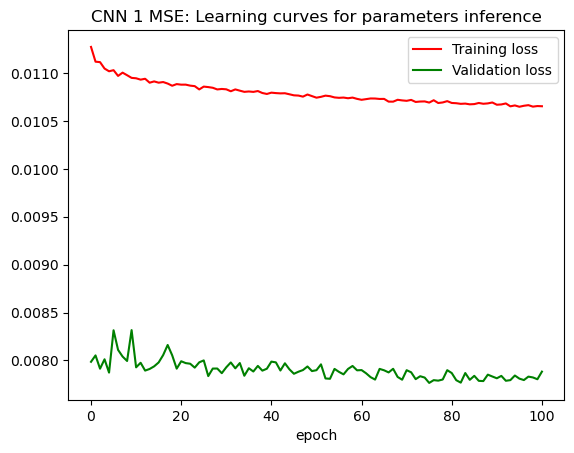

In [58]:
# Training
CNN_1 = keras.models.load_model("New Data/CNN_1")

start=time.time()

history_1 = training(CNN_1, batch_size=2048, patience=100, min_diff=0.001, loss=tf.keras.losses.MeanSquaredError(), optim=tf.keras.optimizers.Nadam(learning_rate=1e-4))
train_duration = time.time()-start 

print(f" Training with {train_size} training data took {train_duration/60} minutes")

# Results
plot_curves("CNN 1 MSE", history_1)

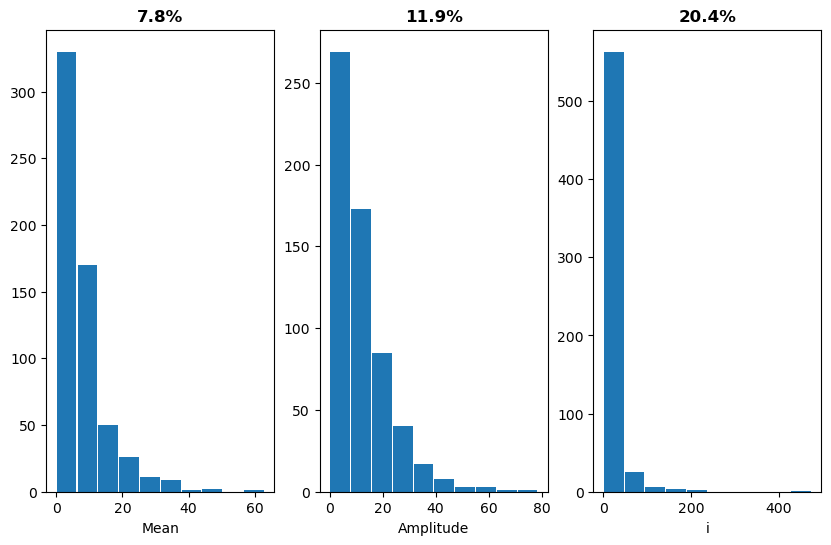

In [60]:
# modb = keras.models.load_model("New Data/CNN_1")
f=compute_error(CNN_1)
plt.show()

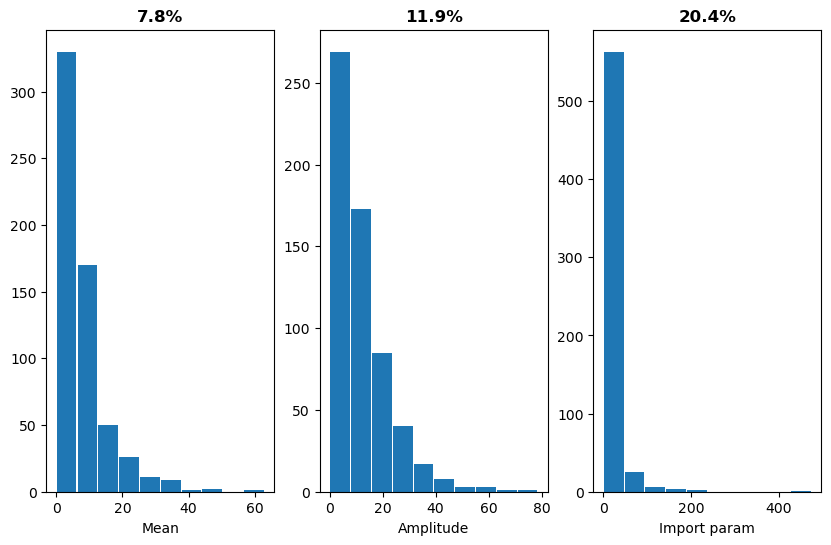

In [299]:
f=compute_error(mod1)
plt.show()

In [79]:
# save if interesting
CNN_1.save("New Data/CNN_1")

2023-01-13 11:01:09.171128: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: New Data/CNN_1/assets


Epoch 1/1000
243/243 [==============================] - 13s 48ms/step - loss: 0.0166 - val_loss: 0.0106
Epoch 2/1000
243/243 [==============================] - 11s 46ms/step - loss: 0.0162 - val_loss: 0.0103
Epoch 3/1000
243/243 [==============================] - 11s 46ms/step - loss: 0.0160 - val_loss: 0.0101
Epoch 4/1000
243/243 [==============================] - 11s 46ms/step - loss: 0.0160 - val_loss: 0.0105
Epoch 5/1000
243/243 [==============================] - 11s 47ms/step - loss: 0.0160 - val_loss: 0.0104
Epoch 6/1000
243/243 [==============================] - 11s 47ms/step - loss: 0.0160 - val_loss: 0.0103
Epoch 7/1000
243/243 [==============================] - 11s 47ms/step - loss: 0.0160 - val_loss: 0.0106
Epoch 8/1000
243/243 [==============================] - 11s 47ms/step - loss: 0.0159 - val_loss: 0.0103
Epoch 9/1000
243/243 [==============================] - 11s 47ms/step - loss: 0.0160 - val_loss: 0.0109
Epoch 10/1000
243/243 [==============================] - 12s 47m

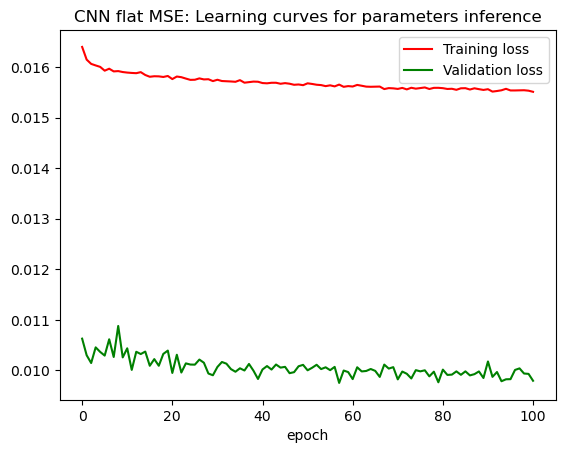

In [282]:
# Training
CNN_flat = keras.models.load_model("New Data/CNN_2")

start=time.time()

history_2 = training(CNN_flat, batch_size=2048, patience=100, min_diff=0.001, loss=tf.keras.losses.MeanSquaredError(), optim=tf.keras.optimizers.Nadam(learning_rate=1e-4))
train_duration = time.time()-start 

print(f" Training with {train_size} training data took {train_duration/60} minutes")

# Results
plot_curves("CNN flat MSE", history_2)

In [286]:
CNN_flat.save("New Data/CNN_2")

INFO:tensorflow:Assets written to: New Data/CNN_2/assets


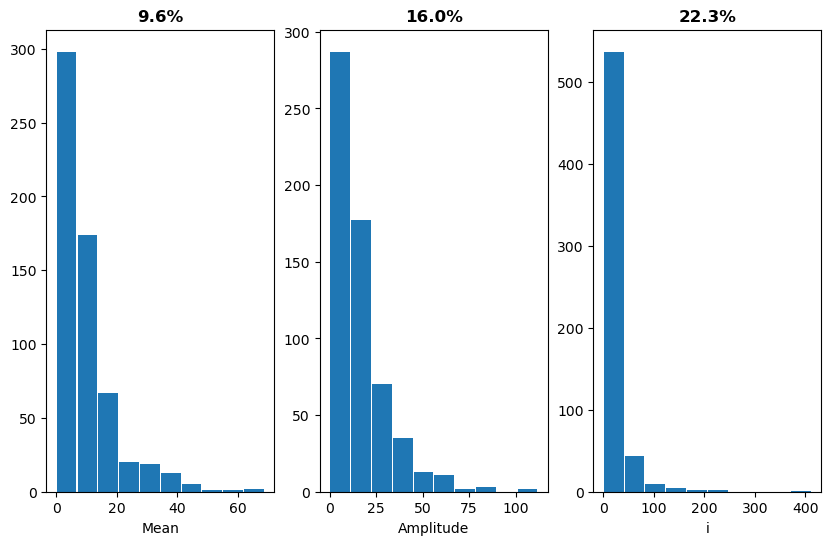

In [283]:
f=compute_error(CNN_flat)
plt.show()

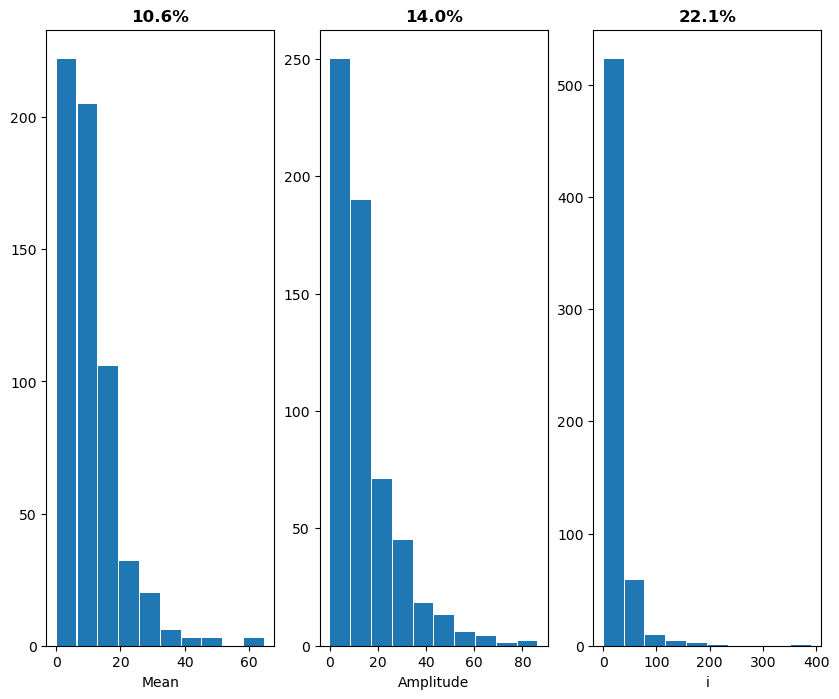

In [17]:
mod = keras.models.load_model("New Data/CNN_2")
f=compute_error(mod)
plt.show()

Epoch 1/1000
486/486 [==============================] - 32s 64ms/step - loss: 0.0166 - val_loss: 0.0176
Epoch 2/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0163 - val_loss: 0.0212
Epoch 3/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0162 - val_loss: 0.0189
Epoch 4/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0162 - val_loss: 0.0206
Epoch 5/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0161 - val_loss: 0.0203
Epoch 6/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 7/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0161 - val_loss: 0.0196
Epoch 8/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0161 - val_loss: 0.0183
Epoch 9/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0161 - val_loss: 0.0209
Epoch 10/1000
486/486 [==============================] - 31s 64m

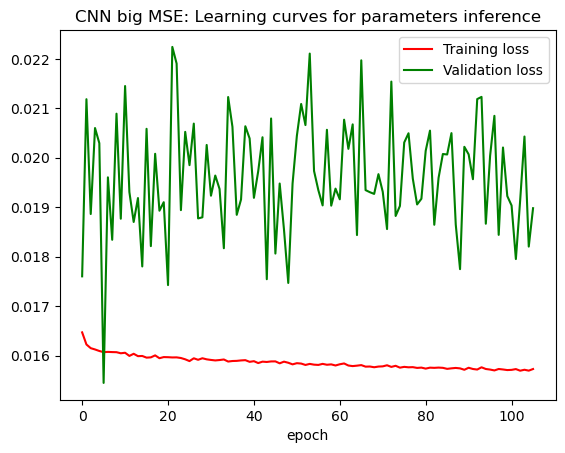

In [284]:
# Training
CNN_big = keras.models.load_model("New Data/CNN_3")

start=time.time()

history_3 = training(CNN_big, batch_size=1024, patience=100, min_diff=0.001, loss=tf.keras.losses.MeanSquaredError(), optim=tf.keras.optimizers.Nadam(learning_rate=1e-4))
train_duration = time.time()-start 

print(f" Training with {train_size} training data took {train_duration/60} minutes")

# Results
plot_curves("CNN big MSE", history_3)

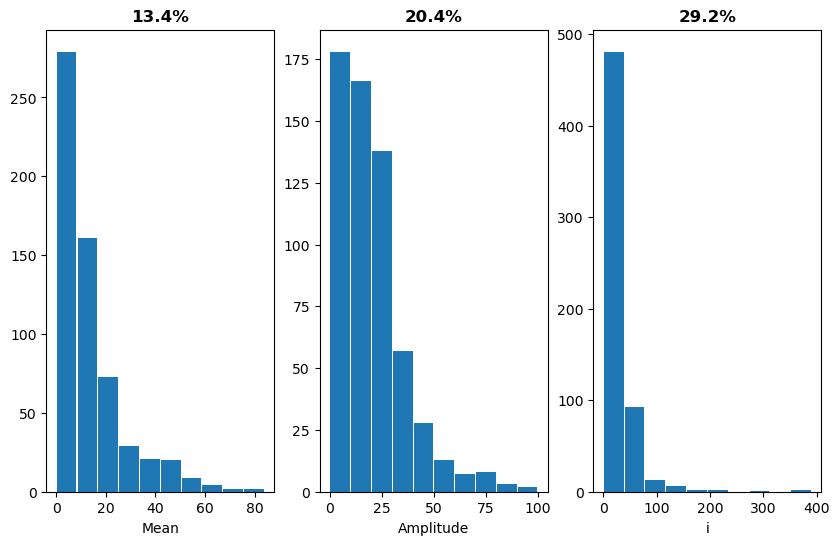

In [287]:
compute_error(CNN_big)
plt.show()

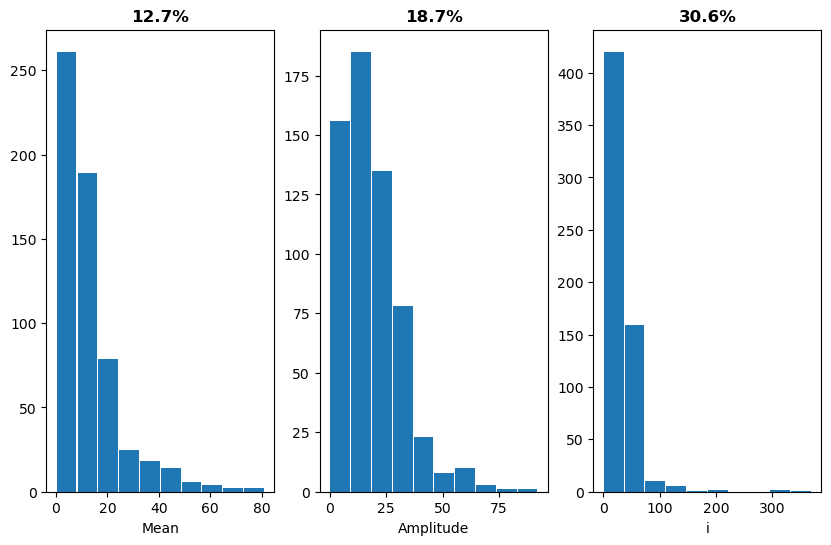

In [290]:
CNN_big= keras.models.load_model("New Data/CNN_3")
compute_error(CNN_big)
plt.show()

In [49]:
CNN_big.save('New Data/CNN_3')

INFO:tensorflow:Assets written to: New Data/CNN_big/assets


# After training

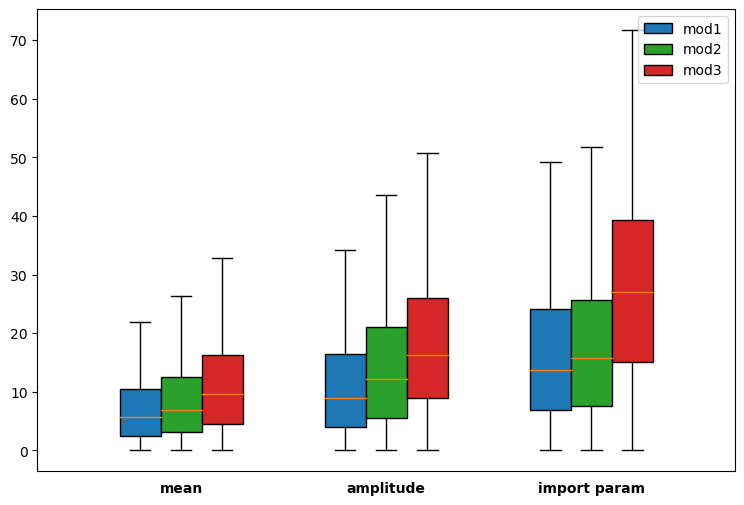

In [293]:
mod1 = keras.models.load_model("New Data/CNN_1")
mod2 = keras.models.load_model("New Data/CNN_2")
mod3 = keras.models.load_model("New Data/CNN_3")

compare(mod1, mod2, mod3)

In [156]:
params_to_infer

['mean_signal', 'amplitude', 'import_param']

## *Relation between accuracy and tree size*

In the Voznica's article, they noticed that the accuracy of deep learning methods increaced with tree size. Let's see with our results ...

In [170]:
from sklearn.linear_model import LinearRegression

def relation_size_error(mod, param, inputs=inputs4[:600]):
    
    RE,_ = compute_error(mod, inputs=inputs, labels=labels4[:600], plot=False)
    
    # Compute the tree size of each input vector 
    X = []
    for vect in inputs:
        leaves = vect[:-1,0]
        X.append(len(leaves[leaves !=0]))

    Regressor = LinearRegression()
    x = np.array([X]).T
    reg = Regressor.fit(x, RE[:, param])
    sc = reg.score(x, RE[:,param])
    print('The coefficient of determination of the prediction ', sc)
    coeff = reg.coef_
    b = reg.intercept_
    
    fig = plt.figure()
    plt.plot(X, RE[:,param], '.r', label='')
    plt.ylim([0,200])
    plt.plot(x, coeff*x+b, label=str(round(coeff[0],4))+'.x+'+str(round(b,2)))
    plt.xlabel('Tree size')
    plt.ylabel('Relative error')
    plt.legend()
    plt.title(params_to_infer[param], fontweight='bold')
    plt.text(100, 180, '$R²:$'+ str(round(sc,3)), fontweight='bold')
#     plt.title('Accuracy of deep learning method according tree size')
    plt.show()
    
    return fig

The coefficient of determination of the prediction  0.15680050909795074


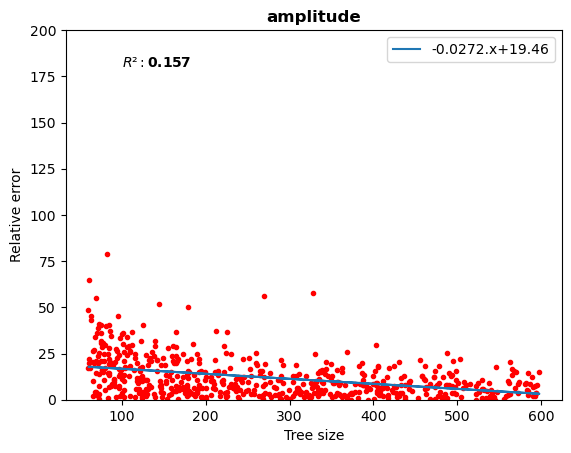

In [171]:
fig = relation_size_error(mod1, 1)

## *Comparision with null models*
To know how much and how fast neural networks learn
Null model 1 : a random predictor (https://www.tensorflow.org/tutorials/customization/custom_layers)

In [294]:
# Null model 1
class RandomPredictor(tf.keras.layers.Layer):
    def __init__(self, num_samples):
        # do all input-independent initialization
        super(RandomPredictor, self).__init__()
        self.num_samples = num_samples
    
    # where you know the shapes of the input tensors and can do the rest of the initialization
    def build(self, input_shape):
        # """
        # parameter_subpace : array of shape (number of parameters, 2) containing min and max values for each parameters
        # """
        
        self.num_param = input_shape[0]

    # do the forward computation
    def call(self, parameter_subspace):
        # """
        # returns : prediction of shape (self.num_samples, self.um_param)
        # """"
        
        random_target = []
        
        for i in range(self.num_param):
            # random_target.append(np.random.uniform(parameter_subspace[i, 0], parameter_subspace[i, 1]))
            random_target.append(np.random.uniform(parameter_subspace[i, 0], parameter_subspace[i, 1], self.num_samples))
            
             
        return tf.transpose(tf.convert_to_tensor(random_target))
    
# TEST 
layer = RandomPredictor(5)
params = np.array([[0,1],  [45,96], [45,85]])
print(params.shape)
layer(param)

(3, 2)


<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[ 0.76671253, 63.22302803, 63.73868394],
       [ 0.63815965, 86.20954509, 45.88484911],
       [ 0.15395381, 79.99564005, 76.52336173],
       [ 0.69904804, 81.48279135, 60.46289466],
       [ 0.79059504, 50.30796285, 70.13853011]])>

In [295]:
factors4 = np.load('New Data/4factors.npy')
factors4

array([10.79288382,  9.96701767, 13.62195035, ..., 12.169696  ,
       10.78128257, 12.86398795])

In [296]:
def error_random_predictor(batch_size, labels, factors):
    
    predictor = RandomPredictor(batch_size)
    
    param_subspace = np.array([[0.3, 0.7], [0.1, 1], [0, 15]])
    random_out = predictor(param_subspace)
    
    # In order to compare the error with the parameter B, we need to rescale random_out[:,0]
    c = random_out[:,0]*factors4[:600]
    random_out=tf.concat([c[:,None], random_out[:,1:]], 1)
    
    RE = tf.math.abs(labels - random_out)*100/labels
    MRE = tf.reduce_mean(RE, axis=0).numpy()
    
    return(RE, MRE)

In [275]:
R, M=error_random_predictor(600, labels4[:600], factors4[:600])
M

array([ 33.69817225, 101.80627387,  62.46330924])

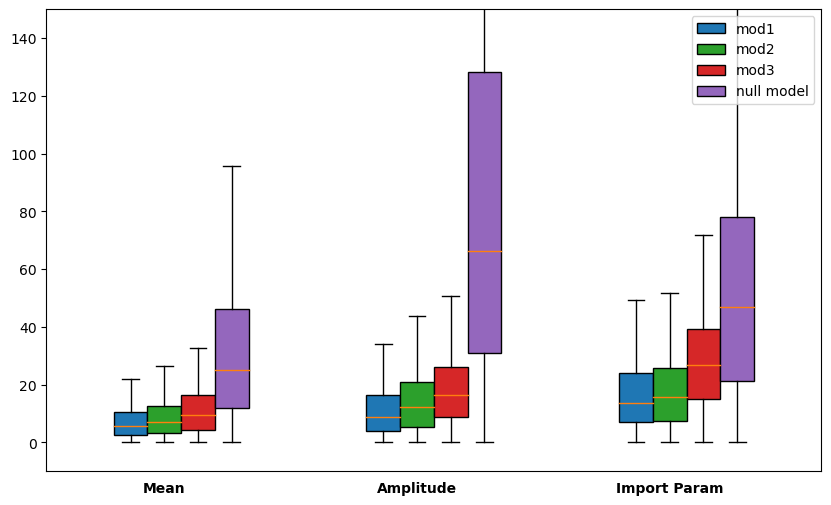

In [298]:
def compare_null(mod1, mod2, mod3):
    
    RE1, _ = compute_error(mod1, plot=False)
    RE2, _ = compute_error(mod2, plot=False)
    RE3, _ = compute_error(mod3, plot=False)
    RE_NULL, MRE_NULL = error_random_predictor(600, labels4[:600], factors4[:600])

    fig, ax = plt.subplots(1,1, figsize=(10, 6))

    t= np.array([1, 2.5, 4])
    bp1 = ax.boxplot(RE1.numpy(),positions=t, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C0"), showfliers=False)

    bp2 = ax.boxplot(RE2.numpy(), positions=t+0.2, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C2"), showfliers=False)

    bp3 = ax.boxplot(RE3.numpy(), positions=t+0.4, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C3"), showfliers=False)
                                
    bp4 = ax.boxplot(RE_NULL.numpy(), positions=t+0.6, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C4"), showfliers=False)
    
    ax.set_ylim([-10,150])


    ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], ['mod1', 'mod2', 'mod3', 'null model'], loc='upper right')

    ax.set_xticklabels(['', '','', 'Mean', 'Amplitude', 'Import Param', '', '', '', '', '',''], fontweight='bold')

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False)         # ticks along the top edge are off


    plt.show()
                                               
compare_null(mod1, mod2, mod3)